In [1]:
!pip -q install vit_pytorch


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
from __future__ import print_function, division

import numpy as np
import os
import glob

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torch.nn.functional as F
from einops import rearrange
import torchvision
from torchvision import datasets
from torchvision import models
from torchvision import transforms
from torch.utils.data import  WeightedRandomSampler
from vit_pytorch import ViT

import matplotlib.pyplot as plt
from collections import Counter
import time


use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

torch.manual_seed(42)

Using CUDA


In [3]:
import os
from torchvision import datasets, transforms

# Data Parameters
DATA_PATH = 'dts-OCT-total'
TRAIN = 'train'
VAL = 'val'
TEST = 'test'
DATASET_TYPE = [TRAIN, VAL, TEST]

# Convert to absolute path
DATA_PATH = os.path.abspath(DATA_PATH)

# Training parameters
BATCH_SIZE = 32
EPOCHS = 20
LR = 0.0003

# Model parameters
IMAGE_SIZE = 224
PATCH_SIZE = 32
DEPTH = 8



In [4]:
# Data transforms
data_transforms = {
    TRAIN: transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    VAL: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]),
    TEST: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]),
}

# Check if the directories exist
for dataset_type in DATASET_TYPE:
    dataset_path = os.path.join(DATA_PATH, dataset_type)
    if not os.path.exists(dataset_path):
        raise FileNotFoundError(f"Directory not found: {dataset_path}")
    else:
        print(f"Directory exists: {dataset_path}")

# Image datasets
image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(DATA_PATH, x), 
        transform=data_transforms[x]
    )
    for x in DATASET_TYPE
}

dataset_sizes = {x: len(image_datasets[x]) for x in DATASET_TYPE}

print("Classes: ")
print(image_datasets[TRAIN].classes)

# Check if image datasets are loaded correctly
for dataset_type in DATASET_TYPE:
    print(f"{dataset_type} dataset size: {dataset_sizes[dataset_type]}")


Directory exists: /workspace/ashutosh/OCT-Retinal Project/dts-OCT-total/train
Directory exists: /workspace/ashutosh/OCT-Retinal Project/dts-OCT-total/val
Directory exists: /workspace/ashutosh/OCT-Retinal Project/dts-OCT-total/test
Classes: 
['CNV', 'DME', 'DRUSEN', 'NORMAL']
train dataset size: 57362
val dataset size: 8324
test dataset size: 16872


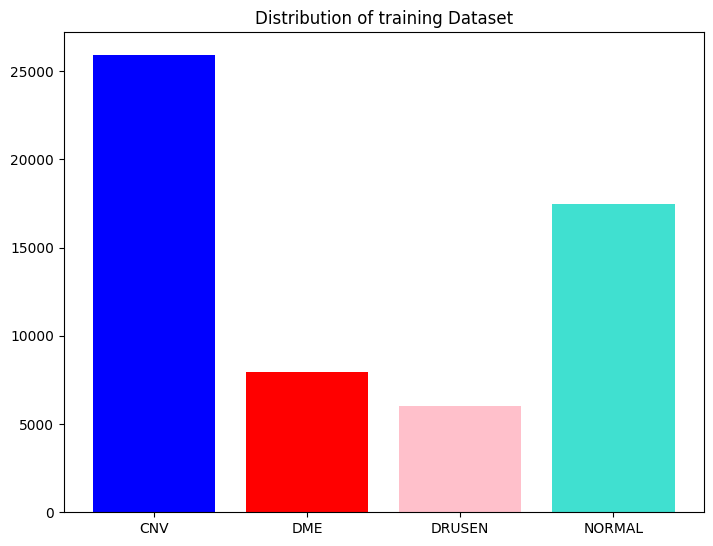

In [5]:
# computing class weights for imbalanced data set

train_targets = [sample[1] for sample in image_datasets[TRAIN].imgs]
counter = Counter(train_targets)
class_count = [i for i in counter.values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float)
train_samples_weight = [class_weights[class_id] for class_id in train_targets]
train_weighted_sampler = torch.utils.data.sampler.WeightedRandomSampler(
    train_samples_weight, dataset_sizes[TRAIN])


# plot training data imbalance

colors = ['blue', 'red', 'pink', 'turquoise']
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(image_datasets[TRAIN].classes, class_count, color=colors)
ax.set_title('Distribution of training Dataset');

In [6]:
train_loader = torch.utils.data.DataLoader(
     image_datasets[TRAIN],
     batch_size=BATCH_SIZE,
     sampler=train_weighted_sampler,
#     shuffle=True,
     num_workers=4
 )

test_loader = torch.utils.data.DataLoader(
    image_datasets[TEST],
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4
)


# print dataset size, class
for x in DATASET_TYPE:
    print("Loaded {}  {} images".format(dataset_sizes[x], x))


Loaded 57362  train images
Loaded 8324  val images
Loaded 16872  test images


In [7]:
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip


In [20]:
import torch
import torch.nn as nn
from torchsummary import summary
from einops import rearrange, repeat

MIN_NUM_PATCHES = 16

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dropout = 0.):
        super().__init__()
        self.heads = heads
        self.scale = dim ** -0.5

        self.to_qkv = nn.Linear(dim, dim * 3, bias = False)
        self.to_out = nn.Sequential(
            nn.Linear(dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x, mask = None):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)

        dots = torch.einsum('bhid,bhjd->bhij', q, k) * self.scale

        if mask is not None:
            mask = mask[:, None, None, :]
            dots.masked_fill_(mask == 0, float('-inf'))
            del mask

        attn = dots.softmax(dim=-1)

        out = torch.einsum('bhij,bhjd->bhid', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)
        return out

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, mlp_dim, dropout):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Residual(PreNorm(dim, Attention(dim, heads = heads, dropout = dropout))),
                Residual(PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout)))
            ]))
    def forward(self, x, mask = None):
        for attn, ff in self.layers:
            x = attn(x, mask = mask)
            x = ff(x)
        return x

class ConvTransformer(nn.Module):
    def __init__(self, image_size, num_classes, dim, depth, heads, mlp_dim, channels = 3, dropout = 0., emb_dropout = 0.):
        super().__init__()
        self.dim = dim
        self.conv_embed = nn.Sequential(
            nn.Conv2d(channels, dim, kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            nn.Conv2d(dim, dim, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(dim, dim, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        self.transformer = Transformer(dim, depth, heads, mlp_dim, dropout)
        self.to_cls_token = nn.Identity()
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img, mask = None):
        x = self.conv_embed(img)
        _, _, h, w = x.shape
        x = rearrange(x, 'b c h w -> b (h w) c')
        x = self.transformer(x, mask)
        x = self.to_cls_token(x[:, 0])
        return self.mlp_head(x)

# Create model instance
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ConvTransformer(
    image_size=224,
    num_classes=4,
    dim=64,
    depth=6,
    heads=8,
    mlp_dim=128,
    channels=3,
    dropout=0.1,
    emb_dropout=0.1
).to(device)

# Create a dummy input tensor with shape (batch_size, channels, height, width)
input_tensor = torch.randn(1, 3, 224, 224).to(device)

# Print the summary of the model
summary(model, (3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
              ReLU-2         [-1, 64, 112, 112]               0
            Conv2d-3           [-1, 64, 56, 56]          36,928
              ReLU-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 28, 28]          36,928
              ReLU-6           [-1, 64, 28, 28]               0
         LayerNorm-7              [-1, 784, 64]             128
            Linear-8             [-1, 784, 192]          12,288
            Linear-9              [-1, 784, 64]           4,160
          Dropout-10              [-1, 784, 64]               0
        Attention-11              [-1, 784, 64]               0
          PreNorm-12              [-1, 784, 64]               0
         Residual-13              [-1, 784, 64]               0
        LayerNorm-14              [-1, 

In [21]:
import torch
import torch.nn.functional as F

def train_epoch_vit_conv_transformer(model, optimizer, train_loader, train_loss_history):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * data.size(0)
        _, predicted = torch.max(output, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

    epoch_loss = running_loss / total
    train_loss_history.append(epoch_loss)
    accuracy = correct / total
    return epoch_loss, accuracy


In [22]:
import torch
import torch.nn.functional as F

def evaluate_conv_transformer(model, test_loader, test_loss_history):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.cross_entropy(output, target)

            running_loss += loss.item() * data.size(0)
            _, predicted = torch.max(output, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

    epoch_loss = running_loss / total
    test_loss_history.append(epoch_loss)
    accuracy = correct / total
    return epoch_loss, accuracy


In [23]:
import time
import torch.optim as optim
import torch

start_time = time.time()

# Corrected model instantiation
model = ConvTransformer(image_size=224, num_classes=4, channels=3, dim=64, depth=6, heads=8, mlp_dim=128)
optimizer = optim.Adam(model.parameters(), lr=0.0003)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

train_loss_history, test_loss_history = [], []
train_acc_history, test_acc_history = [], []  # Initialize the accuracy history lists correctly

# Early stopping parameters
patience = 5
best_loss = float('inf')
trigger_times = 0

for epoch in range(1, 51):
    print('Epoch:', epoch)
    train_loss, train_accuracy = train_epoch_vit_conv_transformer(model, optimizer, train_loader, train_loss_history)
    test_loss, test_accuracy = evaluate_conv_transformer(model, test_loader, test_loss_history)

    # Append accuracy to history lists
    train_acc_history.append(train_accuracy)
    test_acc_history.append(test_accuracy)

    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    # Early stopping logic
    if test_loss < best_loss:
        best_loss = test_loss
        trigger_times = 0
    else:
        trigger_times += 1
        print(f'Early stopping trigger times: {trigger_times}/{patience}')
        if trigger_times >= patience:
            print("Early stopping!")
            break

print('Execution time:', '{:5.2f}'.format(time.time() - start_time), 'seconds')


Epoch: 1
Train Loss: 1.2823, Train Accuracy: 0.3636
Test Loss: 0.7375, Test Accuracy: 0.7165
Epoch: 2
Train Loss: 0.7693, Train Accuracy: 0.6926
Test Loss: 0.5446, Test Accuracy: 0.7932
Epoch: 3
Train Loss: 0.5997, Train Accuracy: 0.7661
Test Loss: 0.5544, Test Accuracy: 0.7934
Early stopping trigger times: 1/5
Epoch: 4
Train Loss: 0.5373, Train Accuracy: 0.7894
Test Loss: 0.3607, Test Accuracy: 0.8717
Epoch: 5
Train Loss: 0.5026, Train Accuracy: 0.8031
Test Loss: 0.3388, Test Accuracy: 0.8868
Epoch: 6
Train Loss: 0.4796, Train Accuracy: 0.8128
Test Loss: 0.3501, Test Accuracy: 0.8732
Early stopping trigger times: 1/5
Epoch: 7
Train Loss: 0.4567, Train Accuracy: 0.8212
Test Loss: 0.3091, Test Accuracy: 0.8893
Epoch: 8
Train Loss: 0.4382, Train Accuracy: 0.8283
Test Loss: 0.3047, Test Accuracy: 0.8893
Epoch: 9
Train Loss: 0.4320, Train Accuracy: 0.8306
Test Loss: 0.3149, Test Accuracy: 0.8909
Early stopping trigger times: 1/5
Epoch: 10
Train Loss: 0.4234, Train Accuracy: 0.8360
Test Los

In [24]:
# Evaluate the model on the validation data
test_loss, test_accuracy = evaluate_conv_transformer(model, test_loader, [])

print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_accuracy:.4f}')


Test loss: 0.2973
Test accuracy: 0.8963


In [25]:
# Evaluate the model on the training data
train_loss, train_accuracy = evaluate_conv_transformer(model, train_loader, [])

print(f'Training loss: {train_loss:.4f}')
print(f'Training accuracy: {train_accuracy:.4f}')


Training loss: 0.3766
Training accuracy: 0.8528


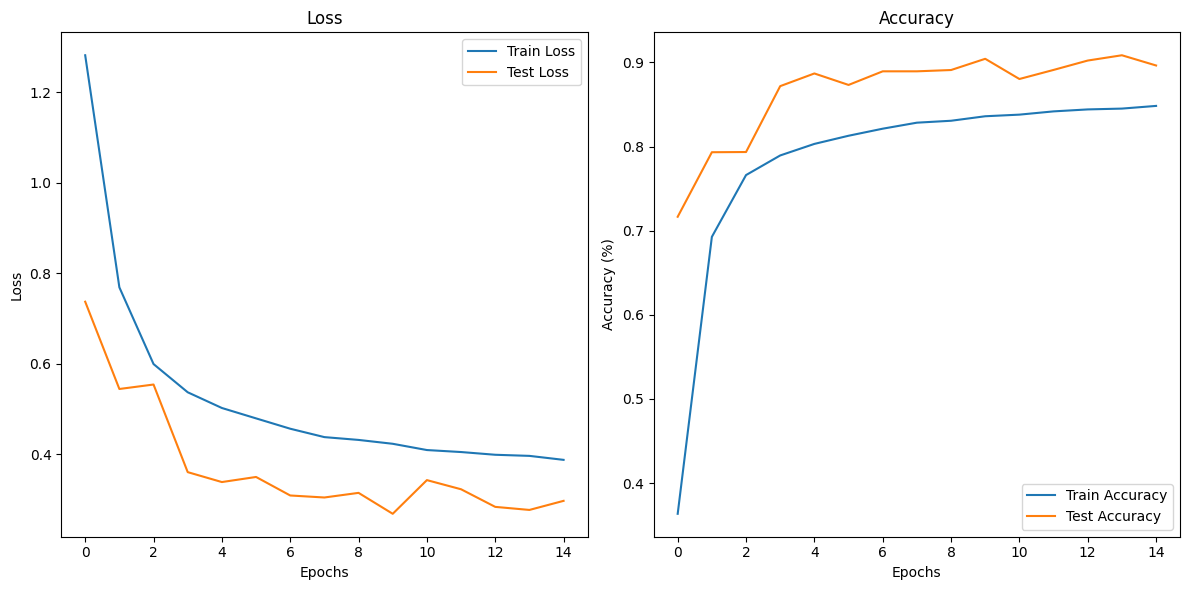

In [28]:
plt.figure(figsize=(12, 6))

# Plotting training loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(test_loss_history, label='Test Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(test_acc_history, label='Test Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


In [31]:
!pip install seaborn


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip


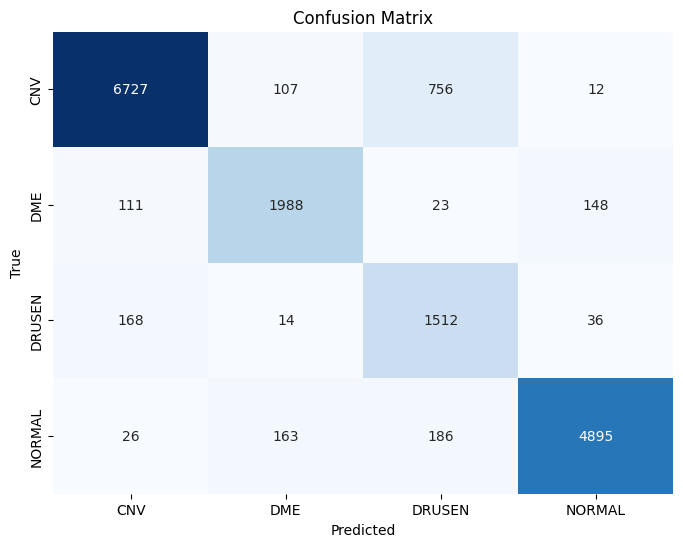

In [32]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Define your class names according to your dataset
class_names = ['CNV', 'DME', 'DRUSEN', 'NORMAL']

# Move model to the correct device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Evaluate the model on the test dataset to get predictions
y_true = []
y_pred = []

model.eval()  # Set model to evaluation mode

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)  # Move data and target to the correct device
        output = model(data)
        _, pred = torch.max(output, 1)
        y_true.extend(target.cpu().numpy())  # Move target to CPU and convert to numpy
        y_pred.extend(pred.cpu().numpy())  # Move predictions to CPU and convert to numpy

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)

# Set class names as labels
plt.xticks(ticks=np.arange(len(class_names))+0.5, labels=class_names)
plt.yticks(ticks=np.arange(len(class_names))+0.5, labels=class_names)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
